In [3]:
import numpy as np
import pandas as pd
import _pickle as pickle
from collections import defaultdict
import re
import ast

from bs4 import BeautifulSoup

import sys
import os
import json
import operator

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

from keras import optimizers

from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, GlobalAveragePooling1D, LSTM, GRU, Bidirectional, dot, multiply, Lambda, TimeDistributed, Masking

from keras.models import Model, Sequential
from keras.regularizers import l2,l1,l1_l2
from keras.callbacks import Callback,EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

from keras.callbacks import Callback

from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [4]:
def load_data(data_name):
    f = open(data_name,'rb')
    data = pickle.load(f)
    return data


In [5]:
MAX_PARA_LENGTH = 250
MAX_PARAS = 200
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100
#VALIDATION_SPLIT = 0.2
#lr = 0.0005
opt = optimizers.Adam(lr= 0.0005)
#l1_reg = l1(1e-5)
l12_reg = l1_l2(l1 = 1e-6,l2 = 1e-6)
BATCH_SIZE = 24
#metrics_auc = {}
metrics_prcs = {}
epochs_num = 35
#num_folder = 5
path = '/home/jujun/fraudprediction_10k/data/'
hanpath = '/home/jujun/fraudprediction_10k/HAN/cp-{epoch:04d}.ckpt'
date = '20200225'


In [6]:
with open(path + 'word_index_50000_20200215','rb') as fp:
    word_index_50000 = pickle.load(fp)

type(word_index_50000)


data = np.load(path + 'handata_20200215.npy')
print("data shape:", data.shape)

embedding_matrix = np.load(path +'embedding_matrix_20200215.npy')
print("embeddng matrix shape:", embedding_matrix.shape)


train_labels = load_data(path +'y_train_20200214')
print(len(train_labels))

test_labels = load_data(path + 'y_test_20200214')
print(len(test_labels))


train_indecis = load_data(path + 'indices_train_20200214')
print(len(train_indecis))

test_indecis = load_data(path + 'indices_test_20200214')
print(len(test_indecis))

X_train = data[train_indecis]
X_test = data[test_indecis]

print(X_train.shape)
print(X_test.shape)

ModelName = hanpath + 'hanmodel_l1l2_drpt' + date 

y_train = pd.Series(train_labels)

y_train.shape
print("y train:", y_train.value_counts())

y_test= pd.Series(test_labels)
print("y test:", y_test.value_counts())




data shape: (56288, 200, 250)
embeddng matrix shape: (50001, 100)
45030
11258
45030
11258
(45030, 200, 250)
(11258, 200, 250)
y train: 0    44625
1      405
dtype: int64
y test: 0    11157
1      101
dtype: int64


In [7]:
def get_word(value):
    return {k:v for k,v in word_index_50000.items() if v == value}


def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate


class Evaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            score_ap = average_precision_score(self.y_val, y_pred)
            logs['Avg_Prec'] = score_ap
            #tencile=performance_measure(y_pred, self.y_val)
            #logs['tencile'] = tencile
            print(" epoch:{:d} AUC: {:.4f}".format(epoch, score))
            print(" epoch:{:d} Avg_Prec: {:.4f}".format(epoch, score_ap))


# class PrecisionEvaluation(Callback):
#     """ Show average Precision after interval number of epoches """
#     def __init__(self, validation_data=(), interval=1):
#         super(Callback, self).__init__()
#         self.interval = interval
#         self.X_val, self.y_val = validation_data

#     def on_epoch_end(self, epoch, logs={}):
#         if epoch % self.interval == 0:
#             y_pred = self.model.predict(self.X_val, verbose=0)
#             score = average_precision_score(self.y_val, y_pred)
#             logs['Avg_Prec'] = score
#             #tencile=performance_measure(y_pred, self.y_val)
#             #logs['tencile'] = tencile
#             #print('prec_socre',score)
#             print(" epoch:{:d} Avg_Prec: {:.4f}".format(epoch, score))



class AttLayer(Layer):
    
    def __init__(self, regularizer=None,context_dim=100, name="attention",**kwargs):
        self.regularizer = regularizer
        self.context_dim=context_dim
        self.supports_masking = True
        self.name=name
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3        
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.context_dim), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='b', shape=(self.context_dim,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.u = self.add_weight(name='u', shape=(self.context_dim,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)        
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x, self.W) + self.b)
        eij = K.squeeze(K.dot(eij, K.expand_dims(self.u, axis=1)), axis=-1)
        ai = K.exp(eij)

        
        if mask is not None:
            ai*=K.cast(mask, K.floatx())
            
        ai /=K.cast(K.sum(ai, axis=1, keepdims=True)+K.epsilon(), K.floatx())

        return ai
        

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    
    def get_config(self):
        config = {}
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask):
        return None    





class WeightedSum(Layer):
    def __init__(self, name="weighted_sum",  **kwargs):
        self.supports_masking = True
        self.name=name
        super(WeightedSum, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(WeightedSum, self).build(input_shape)  # Be sure to call this at the end


    def call(self, input_tensor, mask=None):
        
        x = input_tensor[0]
        #print("input",K.int_shape(x))
        a = input_tensor[1]
        print("weights", K.int_shape(a))

        a = K.expand_dims(a)
        weighted_input = K.sum(x * a, axis=1)
        #print("weighted sum",K.int_shape(weighted_input))
        
        return weighted_input

    def compute_output_shape(self, input_shape):
        
        a, b = input_shape
        
        return (a[0], a[-1])

    def compute_mask(self, x, mask=None):
        return None





def basicModel(embedding_matrix,MAX_NB_WORDS,MAX_PARA_LENGTH,):
    embedding_layer = Embedding((MAX_NB_WORDS+ 1),
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            mask_zero=True,
                            input_length=MAX_PARA_LENGTH,
                            trainable=True)    
    
    
    para_input = Input(shape=(MAX_PARA_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(para_input)
    norm_sequence = BatchNormalization()(embedded_sequences)
    drop_out = Dropout(0.2)(norm_sequence)
    l_att = AttLayer(regularizer = l12_reg)(drop_out)
    weighted_sum = WeightedSum()([drop_out,l_att])
    paraEncoder =Model(para_input,weighted_sum)
    paraEncoder.summary()
    
    doc_input = Input(shape=(MAX_PARAS, MAX_PARA_LENGTH), dtype='int32')
    doc_encoder = TimeDistributed(paraEncoder)(doc_input)
    mask_doc = Masking(mask_value=0.0)(doc_encoder)
    norm_doc = BatchNormalization()(mask_doc)
    l_lstm_para = LSTM(100, return_sequences=True,\
                      implementation=2, \
                      recurrent_dropout = 0.2,
                      dropout=0.2)(norm_doc)
    norm_doc_1 = BatchNormalization()(l_lstm_para)
    l_att_para = AttLayer(regularizer=l12_reg)(norm_doc_1)
    weighted_sum_doc = WeightedSum()([norm_doc_1, l_att_para])

    batch_norm = BatchNormalization()(weighted_sum_doc)

    drop_out = Dropout(0.2)(batch_norm)

    preds = Dense(1, activation='sigmoid',kernel_regularizer=l12_reg)(drop_out) 

    model = Model(doc_input, preds)
    model.summary()
    
    return model





def trainModel(x_train, y_train, Model_Filepath, model):
    
    
    #class_weights = class_weight.compute_class_weight('balanced',
    #                                             np.unique(y_train),
    #                                             y_train)
    #print("class weights:", class_weights)
    
    class_weights = {0: 1, 1:10.0}
    print("class weights:", class_weights)
    
#     val_class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(y_val),
#                                              y_val)
#     print("validation class weights:", val_class_weights)
    
#     val_sample_weights = []
#     for y in y_val:
#         if y == 1:
#             val_sample_weights.append(val_class_weights[1])
#         else: val_sample_weights.append(val_class_weights[0])
#     val_sample_weights = np.asarray(val_sample_weights)
    
#    print(val_sample_weights[0:10])
    
#    print("shape of weights: ",val_sample_weights.shape, "shape y_val: ", y_val.shape)
    
    model.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics=['acc'])
    
    auc_ap_eval = Evaluation(validation_data=(x_train, y_train), interval=1)
    #precision_eval = PrecisionEvaluation(validation_data=(x_train, y_train), interval=1)
    
    #earlyStopping = EarlyStopping(monitor='Avg_Prec',patience = 5, verbose =2, mode ='max')
    checkpoint = ModelCheckpoint(Model_Filepath,save_weights_only=True, period=5)
    #monitor='Avg_Prec', verbose=2, save_best_only=True, mode ='max')
                                 
    print("training start...")
    training=model.fit(x_train,y_train,epochs=epochs_num,batch_size=BATCH_SIZE,callbacks=[auc_ap_eval,checkpoint],
                           class_weight = class_weights,verbose=2) #validation_data=[x_val,y_val,val_sample_weights],earlyStopping,
      
#     hist_data = list(zip(training.history['acc'],\
#                                  training.history['loss'],\
#                                  training.history['val_acc'],\
#                                  training.history['val_loss'],\
#                                  training.history['auc'],
#                                  training.history['Avg_Prec']))
#     hist_data=pd.DataFrame(hist_data, \
#                                    index = range(len(training.history['acc'])),
#                                    columns =['acc','loss','val_acc','val_loss','auc','Avg_Prec'])
                                 
                                 
#     hist_data[['acc','val_acc','Avg_Prec','auc']].plot.line()
#     plt.savefig('plot1.pdf') 
#     hist_data[['loss','val_loss']].plot.line()
#     plt.savefig('plot2.pdf')
#     plt.close()
            
    
    print('training end...')
    
    return training


In [8]:
basicmodel = basicModel(embedding_matrix,MAX_NB_WORDS,MAX_PARA_LENGTH)

weights (None, 250)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 100)     5000100     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 250, 100)     400         embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 250, 100)     0           batch_normalization_1[0][0]      
________________________________________________________________________

In [9]:
basicmodel.load_weights("/home/jujun/fraudprediction_10k/HAN/cp-0020.ckpthanmodel_l1l2_drpt20200225")
pred = basicmodel.predict(X_test)

In [10]:
test_tb = pd.read_csv('/home/jujun/fraudprediction_10k/data/test_insight_20200214.csv')

In [12]:
test_tb['pred_prob'] = pred

In [13]:
test_tb.head()

,file,cik,label,pred_prob
0,edgar/data/815910/0000815910-04-000041.txt,815910,0,0.000140
1,edgar/data/1294538/0000950124-05-001833.txt,1294538,0,0.000015
2,edgar/data/49401/0000049401-05-000016.txt,49401,0,0.000259
3,edgar/data/1326973/0000950134-07-023627.txt,1326973,0,0.000212
4,edgar/data/1043000/0000950134-06-006443.txt,1043000,0,0.000032


In [14]:
test_tb_fraud = test_tb[test_tb.label == 1]

In [15]:
cik_fraud = list(set(test_tb_fraud.cik))

In [17]:
test_tb_fraud = test_tb[test_tb.cik.isin(cik_fraud)]

In [19]:
pvtb_fraud_han = pd.pivot_table(test_tb_fraud, values='pred_prob', index=['cik'], columns =['label'],
                     aggfunc=[np.average,len], margins=True)

In [20]:
pvtb_fraud_han_ave_1 = pvtb_fraud_han['average'][1].rename('prob_ave')

pvtb_fraud_han_len_1 = pvtb_fraud_han['len'][1].rename('count_lb_1')

tb_lb_1 = pd.concat([pvtb_fraud_han_ave_1, pvtb_fraud_han_len_1],axis=1)

tb_lb_1 = tb_lb_1.drop('All',axis =0)

tb_lb_1 = tb_lb_1.sort_values(by=['count_lb_1'])

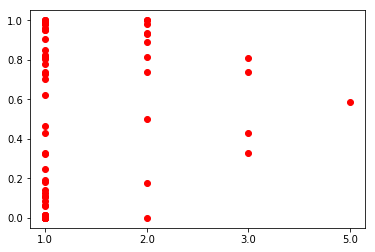

In [21]:
x_axis = [str(i) for i in tb_lb_1.count_lb_1]
plt.plot(x_axis, tb_lb_1.prob_ave,'ro')
plt.show()